In [3]:
##Connecting to my GoogleDrive
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## Importing required packages
import os
import numpy as np
import pandas as pd
import scipy.misc
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from tensorflow.keras.models import Sequential
import cv2
from skimage import io
%matplotlib inline

In [0]:
# Import ImageDataGenerator for image preprocessing/augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest') # 'nearest' is kind of algorithm to fill pixel values while transformation

In [3]:
ls 'drive/My Drive/gender/gender_dataset_face'

man/  transgender/  woman/


In [0]:
# import os
# from keras.preprocessing.image import img_to_array, load_img, array_to_img

# img = load_img('F:\\gender_dataset_face\\gender_dataset_face\\man\\face_0.jpg')  # this is a PIL image
# x = img_to_array(img)  # this is a Numpy array with shape (480, 640, 3)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 480, 640, 3)

# # Create a directory named 'preview' in which we can save augmented images. 
# os.system('mkdir preview')

# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(x, batch_size=1,
#                           save_to_dir='preview', save_prefix='man', save_format='jpg'):
#     i += 1
#     if i > 20:
#         break  # otherwise the generator would loop indefinitely

In [0]:
## Model architecture  

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(256,256,3)))
model.add(Conv2D(64, (1, 1), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (1, 1), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [6]:
## Summary of the Model Architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 258, 258, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 258, 258, 64)      256       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 260, 260, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 260, 260, 64)      4160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 130, 130, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 132, 132, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 130, 128)     7

In [7]:
## Creating the Training file using Flow from Directory
batch_size = 64

# This is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# This is the augmentation configuration we will use for testing:
# Only rescaling. Other transformations are not required for testing.
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'drive/My Drive/gender/gender_dataset_face',  # this is the target directory
        target_size=(256, 256),  # all images will be resized to 256x256
        batch_size=batch_size,
        class_mode='categorical')


Found 2548 images belonging to 3 classes.


Using TensorFlow backend.


[1. 0. 0.]


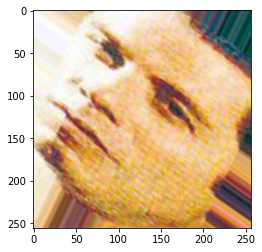

[1. 0. 0.]


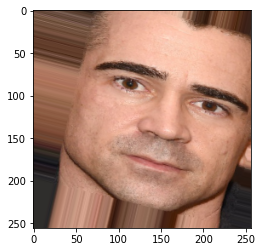

[0. 0. 1.]


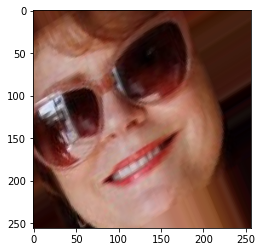

In [8]:
## Checking Images and Corresponding Label
from keras.preprocessing import image
import matplotlib.pyplot as plt

x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

In [9]:
# Shape of an Image
train_generator.image_shape

(256, 256, 3)

In [0]:
## Giving weight to Transgender class as they are less in train
from sklearn.utils import class_weight
class_weight = {0:1.,1: 2.,2: 1.}

In [11]:
# fit_generator is similar to 'fit'. But instead of x_train and y_train, we pass 'train_generator' 
# which already has the samples and their corresponding target information.
# 'steps_per_epoch' is number of batches per epoch.
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(train_generator,steps_per_epoch=2307//batch_size,epochs=10,class_weight=class_weight)


Epoch 1/10
36/36 [==============================] - 829s 23s/step - loss: 1.4003 - accuracy: 0.4511
Epoch 2/10
36/36 [==============================] - 94s 3s/step - loss: 1.1131 - accuracy: 0.4520
Epoch 3/10
36/36 [==============================] - 46s 1s/step - loss: 1.0202 - accuracy: 0.4830
Epoch 4/10
36/36 [==============================] - 43s 1s/step - loss: 0.8950 - accuracy: 0.5266
Epoch 5/10
36/36 [==============================] - 43s 1s/step - loss: 0.8386 - accuracy: 0.5733
Epoch 6/10
36/36 [==============================] - 43s 1s/step - loss: 0.7782 - accuracy: 0.6029
Epoch 7/10
36/36 [==============================] - 44s 1s/step - loss: 0.7646 - accuracy: 0.6215
Epoch 8/10
36/36 [==============================] - 43s 1s/step - loss: 0.6760 - accuracy: 0.6815
Epoch 9/10
36/36 [==============================] - 43s 1s/step - loss: 0.6699 - accuracy: 0.6753
Epoch 10/10
36/36 [==============================] - 43s 1s/step - loss: 0.6877 - accuracy: 0.6740


In [0]:
## Saving the Model
model.save('drive/My Drive/gender/my_model_weights1.h5')